# Bio-scales metadata biogeochemical exploration and visualization

This notebook uses metadata from the [Bio-scales study](https://data.microbiomedata.org/details/study/nmdc:sty-11-r2h77870) in the NMDC Data Portal to look at how soil biogeochemical properties from a Botanical Garden `ecosystem_subtype` are related.

In [1]:
# Load essential libraries
library(jsonlite, warn.conflicts=FALSE)
library(dplyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)
library(ggplot2, warn.conflicts=FALSE)
if (!suppressPackageStartupMessages(require('GGally', quiet = TRUE, warn.conflicts = FALSE))) install.packages('GGally', quiet = TRUE); suppressPackageStartupMessages(library(GGally, warn.conflicts=FALSE))


## Get study IDs associated with Bio-Scales sites using API

Using the Python requests library and [NMDC studies find endpoint](https://api.microbiomedata.org/docs#/find/find_studies_studies_get), we can retrieve the study ID for the Bio-Scales study. In this instance we use a `.search` in the filter parameter to look for studies with "Bio-Scales" in the `title`.   More information regarding the API can be found [here](https://github.com/microbiomedata/NMDC_documentation/blob/main/docs/howto_guides/api_gui.md)

In [2]:
base_url = "https://api.microbiomedata.org"
url = paste0(base_url, "/studies?filter=title.search:Bio-Scales")

response = fromJSON(url)
study_ids = response[["results"]][["id"]]
print(study_ids)


[1] "nmdc:sty-11-r2h77870"


## Using the study ids, pull out bio sample IDs 

Note that we are pulling 2000 records at a time until we have retrieved all biosamples for the three study ids above, place the data retrieved for each bio sample into a tibble.


In [3]:
study_id = study_ids[1]

# Prepare a tibble to hold results
dat_all = tibble()

# Set up query
per_page = 2000  # number of records to retrieve per page
filt = paste0("part_of:", study_id) # filter to only get biosamples from the study of interest
get_more = TRUE # flag to indicate whether we need to get more records
page = 1 # page number to retrieve
while (get_more){
    # construct the url for the query
    url = paste0(
        base_url, 
        "/biosamples?filter=", 
        filt,
        "&per_page=",
        per_page,
        "&page=",
        page)
    # get the data
    data = fromJSON(url)
    data_results = data[['results']] %>% as.data.frame() 
    # add the data to the tibble
    dat_all = bind_rows(dat_all, data_results)
    # check if we need to get more records
    if (nrow(dat_all) < data[['meta']]['count']){
        page = page +1
    } else { get_more = FALSE}
}

glimpse(dat_all)


Rows: 416
Columns: 43
$ id                         <chr> "nmdc:bsm-11-6zd5nb38", "nmdc:bsm-11-ahpvvb…
$ name                       <chr> "Rhizosphere soil microbial communities fro…
$ description                <chr> "Rhizosphere soil microbial communities fro…
$ part_of                    <list> "nmdc:sty-11-r2h77870", "nmdc:sty-11-r2h77…
$ env_broad_scale            <df[,2]> <data.frame[26 x 2]>
$ env_local_scale            <df[,2]> <data.frame[26 x 2]>
$ env_medium                 <df[,2]> <data.frame[26 x 2]>
$ host_taxid                 <df[,2]> <data.frame[26 x 2]>
$ collected_from             <chr> "nmdc:frsite-11-xckqtm38", "nmdc:frsite-…
$ type                       <chr> "nmdc:Biosample", "nmdc:Biosample", "nmd…
$ img_identifiers            <list> "img.taxon:3300046665", "img.taxon:33000…
$ samp_name                  <chr> "BESC-904-Co3_16_51 rhizosphere", "GW-95…
$ gold_biosample_identifiers <list> "gold:Gb0291773", "gold:Gb0291786", "gold:G…
$ elev                       <db

## Clean up results
Pull out biosample_id and associated chemical metadata; unnest as needed


In [4]:
df <- dat_all %>%
    select(
        id, ecosystem_subtype,
        calcium, magnesium, potassium, nitrate_nitrogen, manganese, zinc
    ) %>%
    unnest(
        cols = c(
            ecosystem_subtype,
            calcium, magnesium, potassium, nitrate_nitrogen, manganese, zinc
        ), names_sep = "_") %>%
    select(id, ecosystem_subtype, 
           contains("has_numeric_value"),
           contains("has_unit"))
glimpse(df)


Rows: 416
Columns: 14
$ id                                 <chr> "nmdc:bsm-11-6zd5nb38", "nmdc:bsm-1…
$ ecosystem_subtype                  <chr> "Rhizosphere", "Rhizosphere", "Rhiz…
$ calcium_has_numeric_value          <dbl> NA, NA, NA, NA, NA, 2774.35, 2511.0…
$ magnesium_has_numeric_value        <dbl> NA, NA, NA, NA, NA, 578.148, 502.77…
$ potassium_has_numeric_value        <dbl> NA, NA, NA, NA, NA, 168.200, 315.91…
$ nitrate_nitrogen_has_numeric_value <dbl> NA, NA, NA, NA, NA, 20.4010, 0.0000…
$ manganese_has_numeric_value        <dbl> NA, NA, NA, NA, NA, 48.0908, 26.617…
$ zinc_has_numeric_value             <dbl> NA, NA, NA, NA, NA, 13.1545, 4.0774…
$ calcium_has_unit                   <chr> NA, NA, NA, NA, NA, "mg/kg", "mg/kg…
$ magnesium_has_unit                 <chr> NA, NA, NA, NA, NA, "mg/kg", "mg/kg…
$ potassium_has_unit                 <chr> NA, NA, NA, NA, NA, "mg/kg", "mg/kg…
$ nitrate_nitrogen_has_unit          <chr> NA, NA, NA, NA, NA, "mg/kg", "mg/kg…
$ manganese_has_un

## Unit check
Check that all units are the same before dropping from dataframe


In [5]:
# Check that all units are the same before dropping from dataframe
unit_check <- df %>%
    select(contains("has_unit")) %>%
    distinct() 

glimpse(unit_check)


Rows: 2
Columns: 6
$ calcium_has_unit          <chr> NA, "mg/kg"
$ magnesium_has_unit        <chr> NA, "mg/kg"
$ potassium_has_unit        <chr> NA, "mg/kg"
$ nitrate_nitrogen_has_unit <chr> NA, "mg/kg"
$ manganese_has_unit        <chr> NA, "mg/kg"
$ zinc_has_unit             <chr> NA, "mg/kg"


## More dataframe cleaning
Since all units are the same, drop from dataframe; rename columns for easier reading and plotting


In [6]:
df <- df %>%
    select(-contains("has_unit")) %>%
    rename(
        calcium = calcium_has_numeric_value,
        magnesium = magnesium_has_numeric_value,
        potassium = potassium_has_numeric_value,
        nitrate = nitrate_nitrogen_has_numeric_value,
        manganese = manganese_has_numeric_value,
        zinc = zinc_has_numeric_value
    ) 
glimpse(df)


Rows: 416
Columns: 8
$ id                <chr> "nmdc:bsm-11-6zd5nb38", "nmdc:bsm-11-ahpvvb55", "nmd…
$ ecosystem_subtype <chr> "Rhizosphere", "Rhizosphere", "Rhizosphere", "Rhizos…
$ calcium           <dbl> NA, NA, NA, NA, NA, 2774.35, 2511.03, 2596.00, 1841.…
$ magnesium         <dbl> NA, NA, NA, NA, NA, 578.148, 502.777, 456.241, 331.5…
$ potassium         <dbl> NA, NA, NA, NA, NA, 168.200, 315.919, 154.895, 113.5…
$ nitrate           <dbl> NA, NA, NA, NA, NA, 20.4010, 0.0000, 2.1000, 12.8740…
$ manganese         <dbl> NA, NA, NA, NA, NA, 48.0908, 26.6171, 25.9704, 34.86…
$ zinc              <dbl> NA, NA, NA, NA, NA, 13.1545, 4.0774, 2.1120, 5.2868,…


## Plot chemical data in a correlation matrix
Create paired correlation matrix using GGally package's [ggpairs function](https://ggobi.github.io/ggally/articles/ggpairs.html)


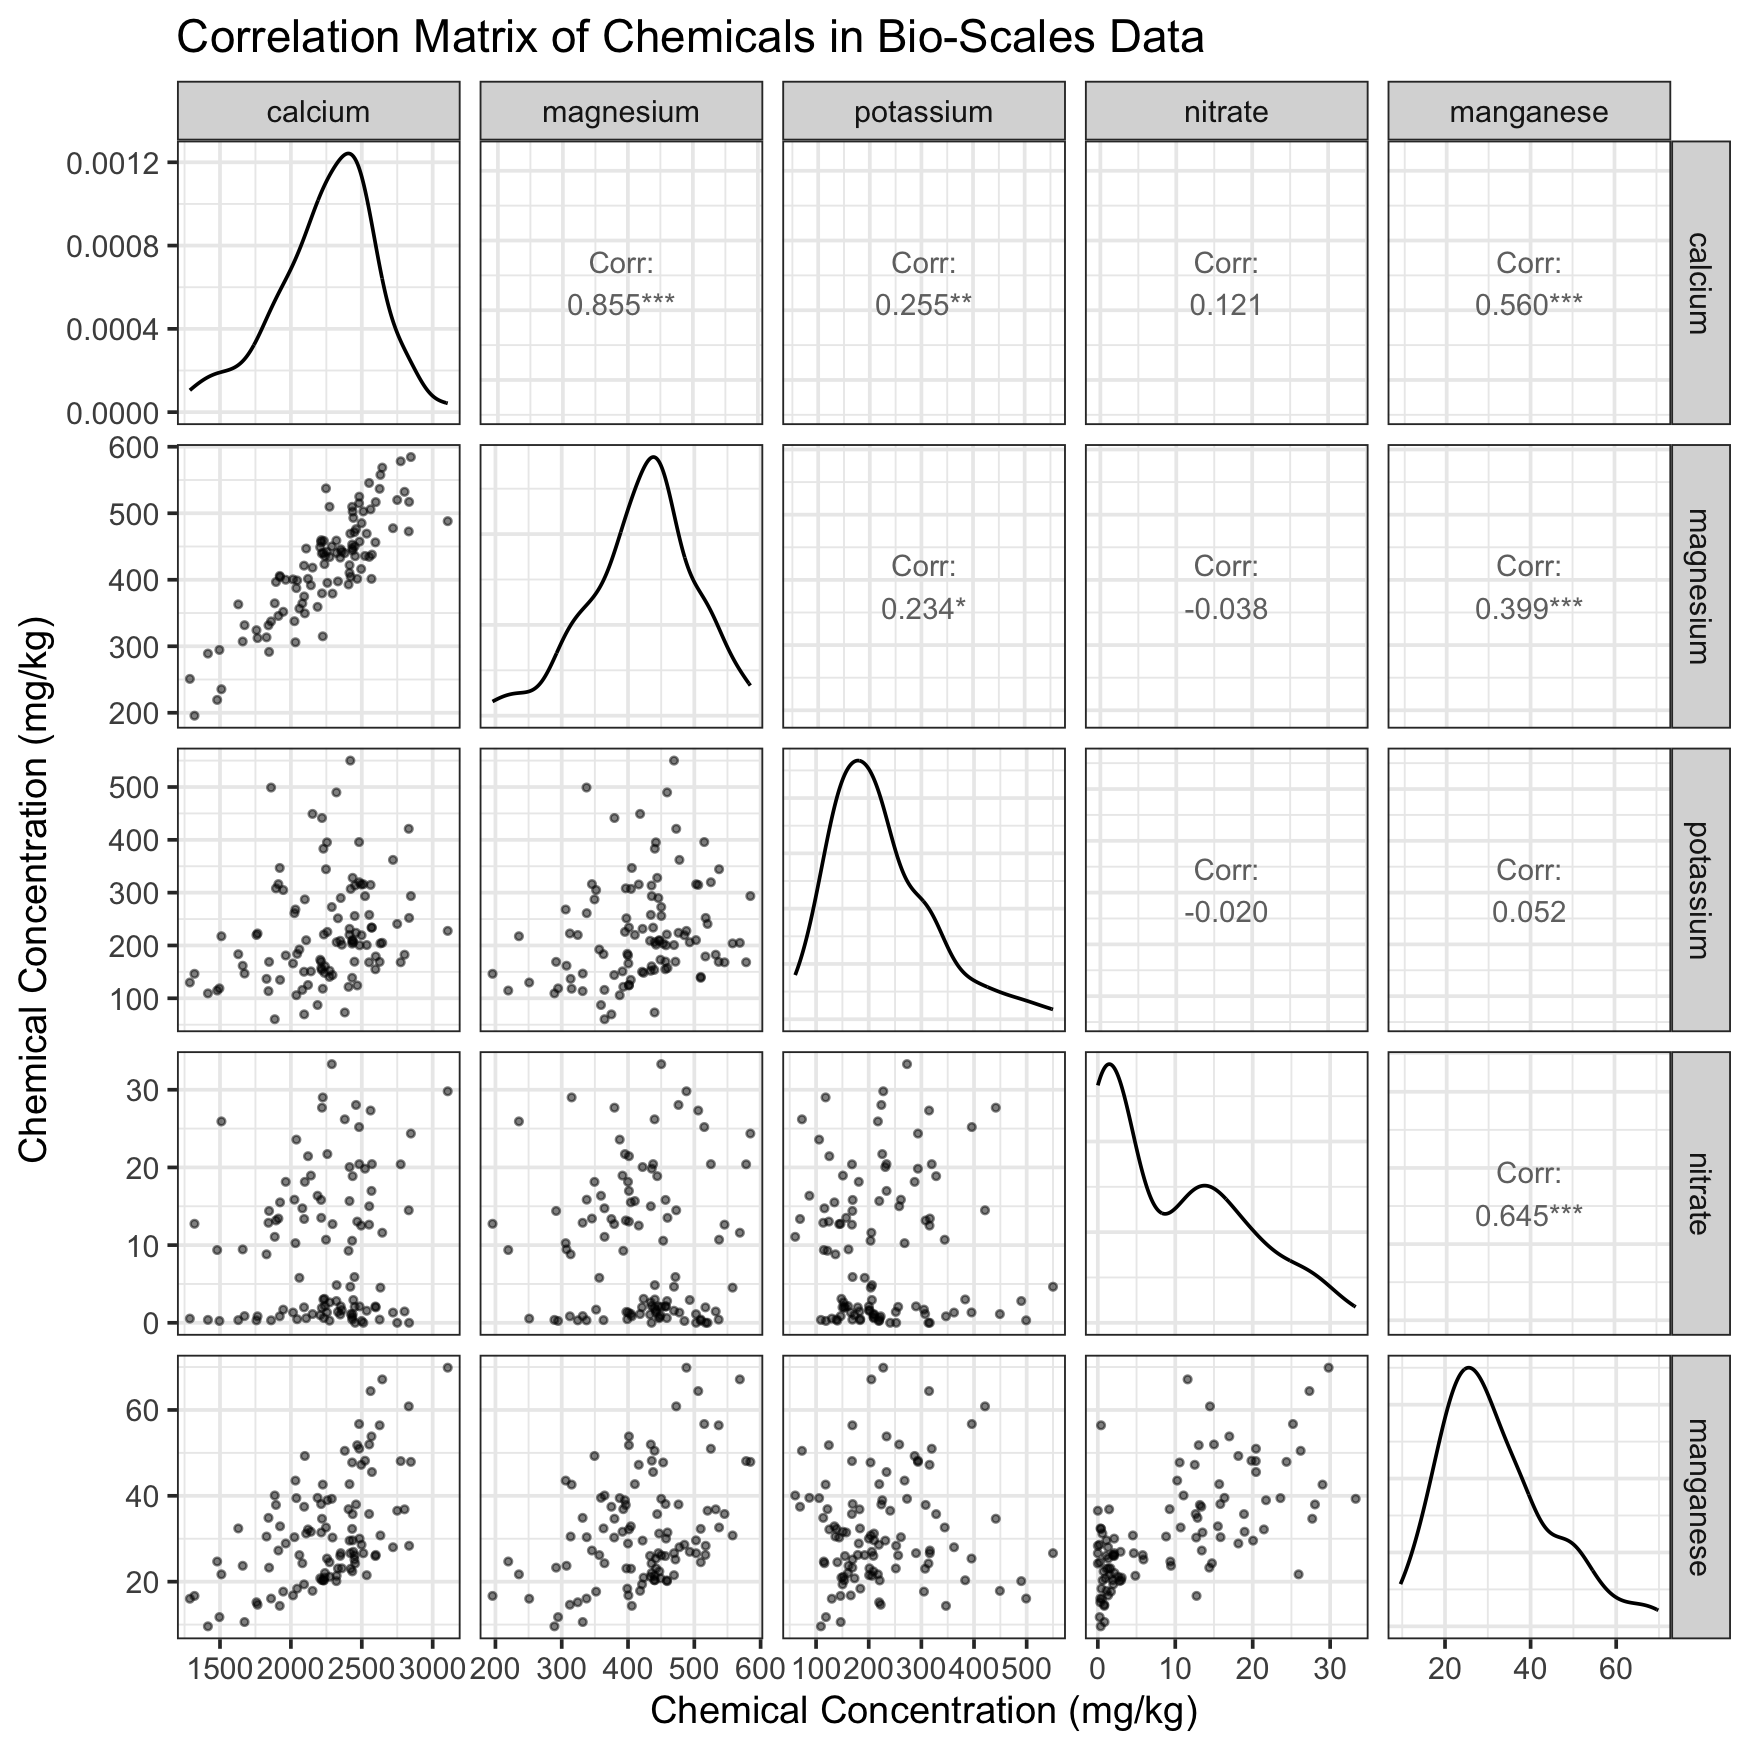

In [7]:
# Drop rows with NAs before plotting to avoid NA warning
df_complete <- na.omit(df)

g <- ggpairs(df_complete, 
        columns = c(3:7), 
        title = "Correlation Matrix of Chemicals in Bio-Scales Data",
        lower = list(continuous = wrap("points", alpha = 0.5, size = 0.7)),
        upper = list(continuous = wrap("cor", size = 3))) +
    theme_bw() +
    labs(
        x = "Chemical Concentration (mg/kg)",
        y = "Chemical Concentration (mg/kg)"
    )

options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 250)
g
